In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import scipy.io as scio
import xarray

#import colorcet as cc
#from cmcrameri import cm
import matplotlib.pyplot as plt
import proplot as pplt
from scipy import stats
import spotpy
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


### Yaling Runoff

In [2]:
YalingRunoff = np.zeros([len(basin_id),240])
for ii in range(235):
    data = scio.loadmat('D:/RunningYalingsData/q_235_basins/235_basins/q_1971_1990_basin_' + str(ii+1) + '.mat')
    QQdata = data['q']
    indx_yl = np.where(basin_id['basin']==(ii+1))[0]
    YalingRunoff[indx_yl, :] = QQdata

# Water Consumption

In [3]:
#Consumption
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
Xanthos_reservoirs = xarray.open_dataset('D:/XanthosDev/example/input/calibration/Xanthos_reservoirs_halfDegree_global.nc')
WaterConsumption_mmpermonth = Xanthos_reservoirs.Total_Water_Consumption.values.transpose()
basin_WC_total = np.zeros([91, 480])
for ii in range(91):
    aa = np.where(basin_id['basin'] == basins94[ii])[0]
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    # basin_WC_total
    basin_WC = WaterConsumption_mmpermonth[basin_idx,:]
    basin_WC_total[ii,:] = np.nanmean(basin_WC,0)

# GRDC

In [4]:
def precip_seasonality(monthly_prcp):
    from datetime import date, timedelta
    sdate = date(1971,1,1)
    edate = date(1990, 12, 31)
    data_ts = pd.DataFrame(monthly_prcp)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
        
    mean_monthly = data_ts.groupby(data_ts.index.month).mean()
    mean_annual  = mean_monthly.sum()
    SI = np.sum(np.abs(mean_monthly - (mean_annual/12))) / mean_annual
    return SI    

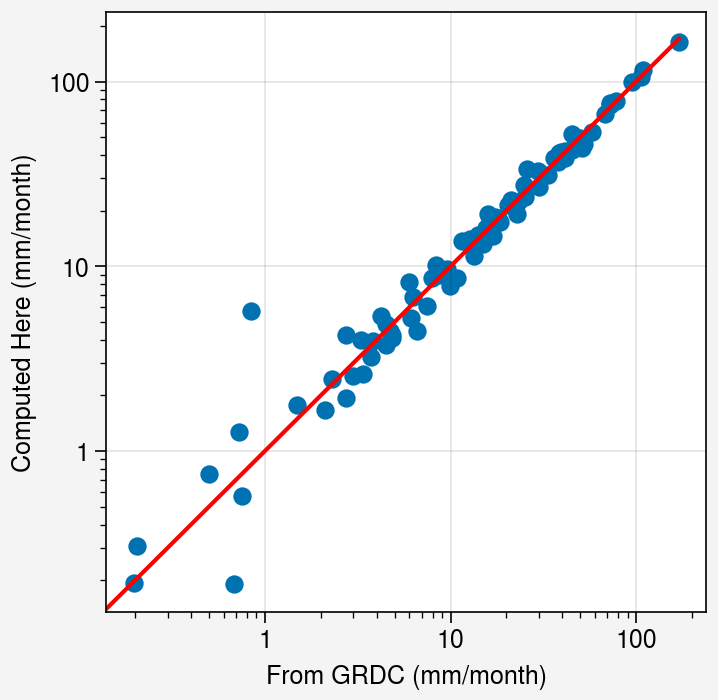

In [5]:
#GRDC
Xanthos_grid_areas = np.array(pd.read_csv('D:/XanthosDev/example/input/reference/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
grdc_mmmPermonth = np.zeros([91, 240])
grdc_m3persec = np.zeros([91, 240])
SI_grdc = np.zeros([91,])
for ii in range(91):
    
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    us_area = np.max([GRDC_xanthosCoordIndx['US_Area_SKM'][ii], GRDC_xanthosCoordIndx['US_Area_SKM'][ii]])   
    if basin_num == 159:
        us_area = GRDC_xanthosCoordIndx['area'][ii]


    ####
    #us_area = GRDC_xanthosCoordIndx['US_Area_SKM'][ii]
    grdc_mmmPermonth[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])*(30.4*24*3600)/us_area/1e3 
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])
    SI_grdc[ii] = precip_seasonality(grdc_m3persec[ii,:])





# plot ggod adjustments
fig, axs = pplt.subplots(nrows=1, ncols=1, share=0, refheight='3in', refwidth='3in')                                           
ax = axs[0]
ax.scatter(GRDC_xanthosCoordIndx['r_height_yr']/12, np.mean(grdc_mmmPermonth, 1))
ax.plot([0, 170], [0, 170], 'r')
ax.format(xscale='log', yscale='log', 
           xlabel='From GRDC (mm/month)', 
           ylabel='Computed Here (mm/month)')

# Precipitation and ET

In [6]:
# get grid indices for the current basin
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
#precipitation
dataP = np.load('D:/XanthosDev/example/input/climate/gswp3_precip_for_calib_1971_2010.npy')
dataPwatch = np.load('D:/XanthosDev/example/input/climate/pr_gpcc_watch_monthly_mmpermth_1971_2001.npy')
#ET
dataET = np.load('D:/XanthosDev/example/input/calibration/' +
                 'ET.RS_METEO.EBC-ALL.MLM-ALL.METEO-GSWP3.720_360.monthly.1971_2010.npy')
dataET[dataET<0] = 0
ETscaler = np.load('D:/XanthosDev/example/input/calibration/ETscaler.npy')

#PET
dataPET = np.load('D:/XanthosDev/example/input/pet/penman_monteith/gswp3_pet_for_calib_1971_2010.npy')
dataPETwatch = np.load('D:/XanthosDev/example/input/pet/penman_monteith/penman_monteith_watch_monthly_pet_1971_2001.npy')


dataET[dataET > dataPET] = dataPET[dataET > dataPET] 

Pmonthly = np.zeros([91,480])
Pmonthlywatch= np.zeros([91,372])
ETmonthly_obs = np.zeros([91,480])
PETmonthly_PM = np.zeros([91,480])
PETmonthly_PMwatch= np.zeros([91,372])
YalingRunoffBasins= np.zeros([91,240])
for ii in range(91):
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    
    #P
    Pmonthly[ii,:] = np.mean(dataP[basin_idx,:],0)
    Pmonthlywatch[ii,:] = np.mean(dataPwatch[basin_idx,:],0)

    # Basin ET, PET
    basinET = np.mean(dataET[basin_idx,:], 0)*ETscaler[ii,1] 
    basinPET = np.mean(dataPET[basin_idx,:],0)
    basinET[basinET > basinPET] = basinPET[basinET > basinPET]
    #ET
    ETmonthly_obs[ii,:] = basinET
    
    #PET
    PETmonthly_PM[ii,:] = basinPET
    PETmonthly_PMwatch[ii,:] = np.mean(dataPETwatch[basin_idx,:],0)   

    #Yaling Runoff
    YalingRunoffBasins[ii,:] = np.mean(YalingRunoff[basin_idx,:], 0)     


# WM

In [7]:
#Xanthos_reservoirs = xarray.open_dataset('D:/XanthosDev/example/input/calibration/Xanthos_reservoirs_halfDegree_global.nc')
Capacity = Xanthos_reservoirs.Capacity.values
Capacity_usgrid = np.zeros([91,2])

for ii in range(91):
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    Capacity_usgrid[ii,0] = basin_num
    Capacity_usgrid[ii, 1] = np.sum(Capacity[basin_idx])  

    

Capacity_usgrid_df = pd.DataFrame(Capacity_usgrid)    
Capacity_usgrid_df.columns = ['Basin','Capacity_MCM']  

# Long-term

In [8]:
long_term_data = pd.DataFrame()
long_term_data['Basin'] = basins94
long_term_data['BasinName'] = basinName_94
long_term_data['Q'] = np.mean(grdc_mmmPermonth,1)
long_term_data['P'] = np.mean(Pmonthly,1)
long_term_data['Pwatch'] = np.mean(Pmonthlywatch,1)
long_term_data['P-Q'] = np.mean(Pmonthly,1) - np.mean(grdc_mmmPermonth,1) 

#long_term_data['WC'] = np.mean(basin_WC_total,1)
long_term_data['ETobs'] = np.mean(ETmonthly_obs,1)
long_term_data['PETpm'] = np.mean(PETmonthly_PM,1)
long_term_data['PETwatch'] = np.mean(PETmonthly_PMwatch,1)
long_term_data['WC'] = np.mean(basin_WC_total,1)

long_term_data['Scaling Coeff.'] = np.divide(long_term_data['P-Q'], long_term_data['ETobs'])
#long_term_data['Scaling Coeff2.'] = np.divide(long_term_data['P-Q2'], long_term_data['ETobs'])
long_term_data['DA'] = GRDC_xanthosCoordIndx['US_Area_SKM']
long_term_data['Capacity_MCM'] = Capacity_usgrid_df['Capacity_MCM']
#long_term_data['lta_discharge_MCM'] = GRDC_xanthosCoordIndx['lta_discharge']*365*24*3600 / 1e6
long_term_data['lta_discharge_MCM'] = np.mean(grdc_m3persec,1)*365*24*3600 / 1e6

long_term_data['RII'] = np.divide(long_term_data['Capacity_MCM'], long_term_data['lta_discharge_MCM'])
#long_term_data[['RII']].boxplot()

# Performance Results filtering

### functions

In [9]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
    ##
    mean_monthly_data = np.squeeze(np.array(data_ts.groupby(data_ts.index.month).mean()))
    mean_annual_data = np.squeeze(np.array(data_ts.resample('A').sum()))

    return mean_monthly_data, mean_annual_data

In [10]:
def runoff_error(performance_data, QQmm, Qwc, qq):
    QRerror = performance_data['R'] - np.mean(QQmm) - np.mean(Qwc)
    performance_data['QRerror'] = np.abs(QRerror) / np.mean(QQmm)
    q10_wbre = performance_data['QRerror'].quantile(q=qq) 
    index1_q10_wbre = (performance_data['QRerror'] <= q10_wbre) 
    QR_filtered_performance_data = performance_data[index1_q10_wbre].reset_index(drop=True)

    return QR_filtered_performance_data

In [11]:
def et_error(performance_data_, qq):    
    q10_ETer = performance_data_['RelativeError'].quantile(q=qq) 
    index1_q10_etre = (performance_data_['RelativeError'] <= q10_ETer)    
    WBRE_filtered_performance_data = performance_data_[index1_q10_etre].reset_index(drop=True)

    return WBRE_filtered_performance_data

In [12]:
def peak_time_differnce(WB_filtered_performance_data, lowRII_Basins, basin_num):   
    if len(np.where(lowRII_Basins==basin_num)[0]) > 0:   
        indx_months_pt1 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -1) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt1].reset_index(drop=True)
        
        if PT_filtered_performance_data.shape[0] < 100:
            indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -2) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
            PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)

        #if PT_filtered_performance_data.shape[0] < 500:
        #    indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -3) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        #    PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)
    else:
        PT_filtered_performance_data = WB_filtered_performance_data
    
    return PT_filtered_performance_data


In [13]:
def runoff_model_output(dir_in, basin_num):
    os.chdir(dir_in)
    basin_calibration =  pd.read_csv('basin_calibration_' + str(basin_num) + 'c.csv')
    basin_calibration = basin_calibration.drop(['para',	'parb',	'parc',	'pard',	'parm'], 1)
    ## basin_abcd
    basin_abcd = basin_calibration[['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5']]
    basin_abcd.columns = ['par_a',	'par_b',	'par_c',	'par_d',	'par_m']
    basin_calibration = basin_calibration.drop(['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5'], 1)

    ######### Runoff
    ## basin annual runoff
    basin_annaul_RO  = basin_calibration[['simulation2_1', 'simulation2_2', 'simulation2_3',
                                            'simulation2_4', 'simulation2_5', 'simulation2_6', 'simulation2_7',
                                            'simulation2_8', 'simulation2_9', 'simulation2_10', 'simulation2_11',
                                            'simulation2_12', 'simulation2_13', 'simulation2_14', 'simulation2_15',
                                            'simulation2_16', 'simulation2_17', 'simulation2_18', 'simulation2_19',
                                            'simulation2_20', 'simulation2_21', 'simulation2_22', 'simulation2_23',
                                            'simulation2_24', 'simulation2_25', 'simulation2_26', 'simulation2_27',
                                            'simulation2_28', 'simulation2_29', 'simulation2_30', 'simulation2_31']]
    basin_annaul_RO.columns = np.arange(1971,2002, 1)   
    ## basin mean monthly runoff
    basin_MM_RO   = basin_calibration[['simulation3_1', 'simulation3_2', 'simulation3_3', 'simulation3_4',
                                        'simulation3_5', 'simulation3_6', 'simulation3_7', 'simulation3_8',
                                        'simulation3_9', 'simulation3_10', 'simulation3_11', 'simulation3_12']]
    basin_MM_RO.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]


    ######## ET
    ## basin annual ET
    basin_annaul_ET  = basin_calibration[['simulation4_1', 'simulation4_2', 'simulation4_3', 'simulation4_4',
                                            'simulation4_5', 'simulation4_6', 'simulation4_7', 'simulation4_8',
                                            'simulation4_9', 'simulation4_10', 'simulation4_11', 'simulation4_12',
                                            'simulation4_13', 'simulation4_14', 'simulation4_15', 'simulation4_16',
                                            'simulation4_17', 'simulation4_18', 'simulation4_19', 'simulation4_20',
                                            'simulation4_21', 'simulation4_22', 'simulation4_23', 'simulation4_24',
                                            'simulation4_25', 'simulation4_26', 'simulation4_27', 'simulation4_28',
                                            'simulation4_29', 'simulation4_30', 'simulation4_31']]
    basin_annaul_ET.columns = np.arange(1971,2002, 1)   

    ## basin mean monthly ET
    basin_MM_ET   = basin_calibration[['simulation5_1','simulation5_2', 'simulation5_3', 'simulation5_4', 'simulation5_5',
                    'simulation5_6', 'simulation5_7', 'simulation5_8', 'simulation5_9',
                    'simulation5_10', 'simulation5_11', 'simulation5_12']]
    basin_MM_ET.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]

    return basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET


In [14]:
def Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat):
    aa1 = pd.DataFrame(annual_ro_mat) - np.mean(annual_ro_mat)
    mm_meanro = np.reshape(np.tile(np.mean(basin_annual_runoff_all, 1),20), 
                                  [20, basin_annual_runoff_all.shape[0]]).transpose()
    aa2 = pd.DataFrame(basin_annual_runoff_all) - mm_meanro
    aa = np.multiply(aa1,aa2).sum(axis=1)
    bb1 = (aa1**2).sum(axis=1)
    bb2 = (aa2**2).sum(axis=1)
    bb = np.sqrt(np.multiply(bb1, bb2))

    rcoeff = np.array(np.divide(aa, bb))

    return rcoeff

In [15]:
def kge_matrix(basin_annual_runoff_all, annual_ro_mat, annual_ro):    
    stdbais_annual_ro  = (1 - (np.std(basin_annual_runoff_all,1) /np.std(annual_ro)))**2
    meanbais_annual_ro = (1 - (np.mean(basin_annual_runoff_all,1) /np.mean(annual_ro)))**2
    rsquared_bias      = ( 1 - Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat))**2
    ed_distance = stdbais_annual_ro + meanbais_annual_ro + rsquared_bias
    kge_value_ = 1 - np.sqrt(ed_distance)
    return kge_value_

## Filter 1 : Annual Runoff

In [16]:
def parameters_set_selection(performance_data_in, grdc_depth, basins94, basin_num): 
    # runoff data
    performance_data = performance_data_in.copy()
    bb = np.where(basins94==basin_num)[0]
    performance_data.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_RP'] = np.array(performance_data.idxmax(axis=1))


    #Q: Peak timing   
    QQmm, QQaa = timeseries_coverter(grdc_depth, start_yr=1971, ending_yr=1990)
    QQmm_df = pd.DataFrame(QQmm)
    QQmm_df.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_QP'] = QQmm_df.idxmax()[0]*np.ones([performance_data.shape[0],])

    # difference
    performance_data['PT_Diff'] = performance_data['MNTH_QP'] - performance_data['MNTH_RP']

    return performance_data

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

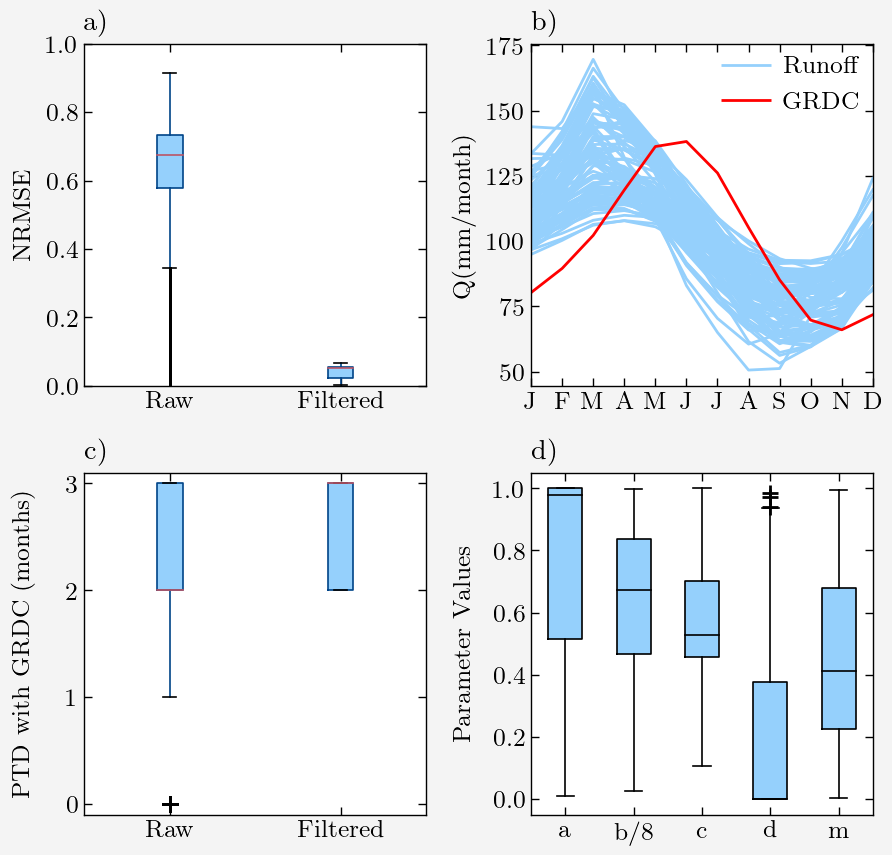

In [20]:
start_yr = 1971
ending_yr = 1990
dir_in = 'D:\\XanthosDev\\Parameter-Selection\\WATCH\\WATCH-1M-Run-abcdm'
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

basin_num = 168#basins94[ii]
bb = np.where(basins94==basin_num)[0]
## Get data : simulated   
basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET = runoff_model_output(dir_in, basin_num)

QQmm, QQaa = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr=1971, ending_yr=1990)
basin_annaul_RO['Qannual_error'] = np.abs(basin_annaul_RO.mean(axis=1) - np.mean(QQaa))/np.mean(QQaa)

basin_annual_runoff = np.array(basin_annaul_RO)
basin_annual_et = np.array(basin_annaul_ET)    
## Get data : observed    
mean_monthly_ro, annual_ro = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr, ending_yr)
mean_monthly_et, annual_et = timeseries_coverter(np.squeeze(ETmonthly_obs[bb,0:240]), start_yr=1971, ending_yr=1990)
# compute metrics
annual_ro_dup = np.multiply(np.ones_like(basin_annual_runoff[:,0:20]),annual_ro)
annual_et_dup = np.multiply(np.ones_like(basin_annual_et[:,0:20]),annual_et)


############ Runoff rmse
rmse_annual_ro = np.sqrt(np.sum((basin_annual_runoff[:,0:20] - annual_ro_dup)**2, 1))  / len(annual_ro)
############ ET rmse
rmse_annual_et = np.sqrt(np.sum((basin_annual_et[:,0:20] - annual_et_dup)**2, 1))  / len(annual_et)

##filter 1
qt1 = 10000/len(rmse_annual_ro)
indxRO_rmse = (rmse_annual_ro <= pd.DataFrame(rmse_annual_ro).quantile(qt1)[0])
filter1_basin_annaul_RO = basin_annaul_RO[indxRO_rmse].reset_index(drop=True)
filter1_basin_annaul_ET = basin_annaul_ET[indxRO_rmse].reset_index(drop=True)
filter1_ai_annual_ro = rmse_annual_ro[indxRO_rmse]
filter1_ai_annual_et = rmse_annual_et[indxRO_rmse]
filter1_params_abcd = basin_abcd[indxRO_rmse].reset_index(drop=True)

filter1_basin_MM_RO = basin_MM_RO[indxRO_rmse].reset_index(drop=True)
filter1_basin_MM_ET = basin_MM_ET[indxRO_rmse].reset_index(drop=True)   

### filter 2
indxET_rmse = (filter1_ai_annual_ro <= pd.DataFrame(filter1_ai_annual_ro).quantile(0.01)[0])
filter2_basin_annaul_RO = filter1_basin_annaul_RO[indxET_rmse].reset_index(drop=True)
filter2_basin_annaul_ET = filter1_basin_annaul_ET[indxET_rmse].reset_index(drop=True)
filter2_ai_annual_et = filter1_ai_annual_ro[indxET_rmse]
filter2_ai_annual_et = filter1_ai_annual_et[indxET_rmse]
filter2_params_abcd = filter1_params_abcd[indxET_rmse].reset_index(drop=True)

filter2_basin_MM_RO = filter1_basin_MM_RO[indxET_rmse].reset_index(drop=True)
filter2_basin_MM_ET = filter1_basin_MM_ET[indxET_rmse].reset_index(drop=True)    


#length_check[ii] = filter2_basin_MM_RO.shape[0]
#############################################################################################    
##################################################
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, axs = pplt.subplots(nrows=2, ncols=2,  share=0, journal='pnas2')
    ############ Water Balance Error
    ax = axs[0]
    new_all_errors = pd.concat([basin_annaul_RO[['Qannual_error']], 
                            #filter1_basin_annaul_RO[['Qannual_error']],
                            filter2_basin_annaul_RO[['Qannual_error']]], ignore_index=False, axis=1)     
    new_all_errors.columns = ['Raw','Filtered']
    new_all_errors.boxplot(ax=ax,facecolor='light blue', sym='+', markersize=1)
    ax.format(ylabel='NRMSE', abcstyle='a)',  grid=False,  titleloc='l')
    ax.set_ylim([0,1])
    ax.minorticks_off()


    ############## Mean Monthly
    ax = axs[1]   
    df = filter2_basin_MM_RO.transpose()
    cols = ["_" + str(col) for col in df.columns]
    cols[0] = 'Runoff'
    df.columns = cols
    df.index = np.arange(0,12,1)

    df.plot(ax=ax, color='light blue', label=str())
    ax.plot(QQmm, 'r', label='GRDC')
    ax.format(ylabel='Q(mm/month)', abcstyle='a)',  grid=False,  titleloc='l')
    major_xticks = np.arange(0, 12, 1)
    ax.set_xticks(major_xticks)
    ax.set_xticklabels(['J','F','M','A','M', 'J','J','A','S','O','N','D'])
    ax.legend(ncols=1)
    ax.minorticks_off()



    ############## Peak time difference
    performance_data = parameters_set_selection(basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins94, basin_num)
    performance_data1 = parameters_set_selection(filter1_basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins94, basin_num)
    performance_data2 = parameters_set_selection(filter2_basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins94, basin_num)
    new_all_peaktime = pd.concat([performance_data[['PT_Diff']], 
                                    #performance_data1[['PT_Diff']],
                                    performance_data2[['PT_Diff']]], ignore_index=False, axis=1)     
    #new_all_peaktime.columns = ['Raw','Filter 1','Filter 2']
    new_all_peaktime.columns = ['Raw','Filtered']
    ax = axs[2]
    new_all_peaktime.boxplot(ax=ax,facecolor='light blue', sym='+')
    ax.set_ylim([-.1, 3.1])
    ax.format(ylabel='PTD with GRDC (months)', abcstyle='a)',  grid=False,  titleloc='l')
    ax.minorticks_off()

    ############## Params
    ax = axs[3]
    params_abcd = pd.DataFrame(np.array(filter2_params_abcd.copy()))
    params_abcd.columns = ['a','b','c','d','m']
    params_abcd['b'] = params_abcd['b']/8

    ax.boxplot(np.array(params_abcd) ,facecolor='light blue', sym='+')
    ax.set_xticklabels(['a','b/8','c','d','m'])     
    ax.format(ylabel='Parameter Values', abcstyle='a)',  grid=False ,  titleloc='l')  
    ax.minorticks_off()


fig.align_ylabels(axs)
plt.tight_layout()   

fgiure_dir = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\figures-v2\\'
plt.savefig(fgiure_dir + "Figure-6-Two-stage parameter selection.png", **SAVE_KWDS)  